# Equations
Here we are solving a set of coupled differential equations gives (from Chapman supplement and Arne notebook)

$$\begin{align}
    i \dot{\zeta}_1&= (p_1 B + q_1 B^2 + q\mu_1(t))\zeta_1+c\left[(\zeta_1^*\zeta_1+\zeta_0^*\zeta_0-\zeta_{-1}^*\zeta_{-1})\zeta_1+\zeta_0\zeta_0\zeta_{-1}^*)\right]\\
    i\dot{\zeta}_0&=(p_0 B + q_0 B^2 + q\mu_0(t))\zeta_0+c\left[(\zeta_1^*\zeta_1 + \zeta_{-1}^*\zeta_{-1})\zeta_0 + 2\zeta_1\zeta_{-1}\zeta_0^*\right]\\
    i \dot{\zeta}_{-1}&= (p_{-1} B + q_{-1} B^2 + q\mu_{-1}(t))\zeta_{-1}+c\left[(\zeta_{-1}^*\zeta_{-1}+\zeta_0^*\zeta_0-\zeta_{1}^*\zeta_{1})\zeta_{-1}+\zeta_0\zeta_0\zeta_{1}^*)\right]\\
\end{align}
$$

# Expectation Values
First we note that 
$$ S_x = \frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
$$
So to calculate its expectation value with a given wavefunction, we have
$$\psi^*S_x \psi =  (\psi_1^*,\psi_0^*,\psi_{-1}^*)\frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
\begin{pmatrix}
\psi_1\\
\psi_0\\
\psi_{-1}
\end{pmatrix} = \frac{(\psi_1^*+\psi_{-1}^*)\psi_0 + \psi_0^*(\psi_{1}+\psi_{-1})}{\sqrt{2}}$$

# Inital State (Hamley thesis and Chapman supplement)
We can represent the initial state as a normal distribution in $S_x,S_y, N_{yz}, N_{xz}$, we can then derive starting conditions from these values and evolve the state.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from numpy.lib import scimath
import seaborn
import time
from tqdm import trange
%matplotlib inline

In [29]:
#first define the system dy/dt = f(y,t)
def msqr(x):
    return x*np.conj(x) 

def f(t,y,*args):
    """system of ode we want to solve"""
    z1i = y[0]
    z0i = y[1]
    zmi = y[2]
    #now define equations
    f0 = (q*z1i + c*((msqr(z1i) + msqr(z0i) - msqr(zmi))*z1i + z0i**2*np.conj(zmi)))*np.complex(0,-1)
    f1 = (c*((msqr(z1i) + msqr(zmi))*z0i) + 2*c*z1i*zmi*np.conj(z0i))*np.complex(0,-1)
    f2 = (q*zmi + c*((msqr(zmi) + msqr(z0i) - msqr(z1i))*zmi + z0i**2*np.conj(z1i)))*np.complex(0,-1)
    return np.asarray([f0,f1,f2])   

class Operator(object):
    """class of operator for 3x3 matrices in this problem"""
    def __init__(self, mat,rep):
        self.rep = rep
        self.mat = mat

    def apply(self,ele):
        return np.dot(ele, np.dot(self.mat,np.conj(ele).T)).real
        #return np.dot(np.conj(ele), np.dot(self.mat,ele.T)).real
    
def find_phase(ele):
    """find the phase theta_1+theta_-1-2theta_0"""
    ans =  np.angle(ele)
    return ans[0] + ans[2] - 2 * ans[1]

def func_int(yn,t):
    return f(t,yn)

def ynplus1(func, yn,t,dt,**kwargs):
    """evolve Runge kutta with function func which takes two input arguments
    yn and t and possibly extra arguments
    :param yn: value at the previous iteration
    :param t: the time at current iteration
    :param dt: time step
    """
    k1 = func(yn,t,**kwargs)
    k2 =  func(yn+dt/2*k1,t+dt/2,**kwargs)
    k3 = func(yn+dt/2*k2,t+dt/2,**kwargs)
    k4 = func(yn+dt*k3,t+dt,**kwargs)
    a = k1+ 2 * k2 + 2 * k3 + k4
    return yn + dt*a/6

In [30]:
S_x = Operator(np.array([[0,1,0],[1,0,1],[0,1,0]])*1/np.sqrt(2),r'$S_x$')
N_yz = Operator(1j/np.sqrt(2)* np.array([[0,-1,0],[1,0,1],[0,-1,0]]),r'$N_{yz}#')
rho_0 = Operator(np.array([[0,0,0],[0,1,0],[0,0,0]]),r'$\rho_0$')

In [57]:
def generate_states(N1,N0,Nm1,theta,s):
    """generate quasi probability distribution"""
    N = N1 + N0 + Nm1
    r0 = N0/N
    r1 = N1/N
    rm1 = Nm1/N
    a = np.sqrt(2*r0*r1)
    b = np.sqrt(2*r0*rm1)
    sx_mean = np.cos(theta/2)*(a+b)
    sy_mean = np.sin(theta/2)*(b-a)
    nyz_mean = -np.sin(theta/2)*(a+b)
    nxz_mean = np.cos(theta/2)*(a-b)
    var_one = N*np.sqrt(r0**2-2*r0*np.sqrt(r1)*np.sqrt(rm1)*np.cos(theta)-r0*r1-r0*rm1+r1**(3/2)*np.sqrt(rm1)*np.cos(theta)+np.sqrt(r1)*rm1**(3/2)*np.cos(theta)+0.25*r1**2+0.5*r1*rm1*np.cos(2*theta) + r1*rm1 + 0.25*rm1**2)
    var_two = N*np.sqrt(r0**2+2*r0*np.sqrt(r1)*np.sqrt(rm1)*np.cos(theta)-r0*r1-r0*rm1-r1**(3/2)*np.sqrt(rm1)*np.cos(theta)-np.sqrt(r1)*rm1**(3/2)*np.cos(theta)+0.25*r1**2+0.5*r1*rm1*np.cos(2*theta) + r1*rm1 + 0.25*rm1**2)
    print(var_one,var_two)
    print(sx_mean,sy_mean,nyz_mean,nxz_mean)
    sx = np.random.normal(loc = sx_mean, scale = 1/np.sqrt(var_one), size = s)
    sy = np.random.normal(loc = sy_mean, scale = 1/np.sqrt(var_two), size = s)
    nyz = np.random.normal(loc = nyz_mean, scale = 1/np.sqrt(var_one), size = s)
    nxz = np.random.normal(loc = nxz_mean, scale = 1/np.sqrt(var_two), size = s)

    
    txip = np.where((sx+nxz)>0,np.arctan(-(sy + nyz)/(sx+ nxz)),np.arctan(-(sy + nyz)/(sx+ nxz))+np.pi)
    txim = np.where((sx-nxz)>0,np.arctan((sy-nyz)/(sx-nxz)),np.arctan((sy-nyz)/(sx-nxz))+np.pi)
    a = (sx+nxz)**2/(np.cos(txip))**2
    b = (sx-nxz)**2/(np.cos(txim))**2

    rho_0 = 1/2 + scimath.sqrt(1/4-(a+b)/8)
    m = 1/rho_0*(a-b)/8
    
    states = np.zeros((len(m),3),dtype = complex)

    states[:,0] = scimath.sqrt((1-rho_0+m)/2) * np.exp(txip*1j)
    states[:,1] = scimath.sqrt(rho_0)
    states[:,2] = scimath.sqrt((1-rho_0-m)/2) * np.exp(txim*1j)

    return states
#solve the sucker and plot
def solve_system_fixed(y0):
    dt = 0.0005
    t = []
    sol = []
    num_steps = int(tfinal/dt)
    for i in range(num_steps):
        sol.append(y0)
        t.append(i*dt)
        y0 = ynplus1(func_int,y0,i*dt,dt)
    t = np.asarray(t)
    sol = np.asarray(sol)
    return t, sol

def solve_system(y0):
    r = ode(f).set_integrator('zvode')
    r.set_initial_value(y0,0)
    sol = []
    t= []
    while r.successful() and r.t < tfinal:
        r.integrate(tfinal, step = True)
        sol.append(r.y)
        t.append(r.t)
    t = np.asarray([t])
    sol = np.asarray(sol)
    return np.concatenate((t.T,sol), axis = 1)

def get_exp_values(ans,step_size):
    """function to compute expectation values"""
    sol = ans[:,1:]
    #r_0 = np.asarray([rho_0.apply(i) for i in sol[::step_size]]).real
    r_0 = np.asarray([np.conj(i[1]) * i[1] for i in sol[::step_size]]).real
    sx_calc = np.asarray([S_x.apply(i) for i in sol[::step_size]]).real
    nyz_calc = np.asarray([N_yz.apply(i) for i in sol[::step_size]]).real
    phase = np.asarray([find_phase(i) for i in sol[::step_size]]).real
    return np.asarray([ans[:,0][::step_size].real,r_0, sx_calc, nyz_calc, phase]), len(ans[:,0][::step_size])

def solve_TWA():
    #alot array for computation
    step_size = 1
    ans = []
    t_max = 0
    t_index = 0
    #do calculation
    for i,state in enumerate(states):
        vals, t_num = get_exp_values(solve_system(state),step_size)
        ans.append(vals)
        if t_num > t_max:
            t_max = t_num
            t_index = i
    ans_1 = ans
    t_interp = ans_1[t_index][0]
    #alot array for interpolation
    ans = np.zeros((len(states),4,len(t_interp)))
    for i, vals in enumerate(ans_1):
        for j, row in enumerate(vals[1:]):
            ans[i,j] = np.interp(t_interp,vals[0],row)

    #output routine
    m = np.mean(ans[:,0],axis = 0)
    s = np.std(ans[:,0],axis = 0)
    return t_interp,m,s

def solve_TWA_fixed():
    #alot array for computation
    step_size = 1
    ans = []
    sols = []
    #do calculation
    for i in trange(len(states)):
        state = states[i]
        t, sol = solve_system_fixed(state)
        sols.append(sol)
        #get expectation values
        rho = np.asarray([i[1]*np.conj(i[1]) for i in sol]).real
        ans.append(rho)
   
    ans = np.asarray(ans)
    m = np.mean(ans,axis=0)
    std = np.std(ans,axis =0)
    return t, m,std, sols


2000.0 6000.0
0.979795897113 0.0 -0.0 0.0
0.0
0.0


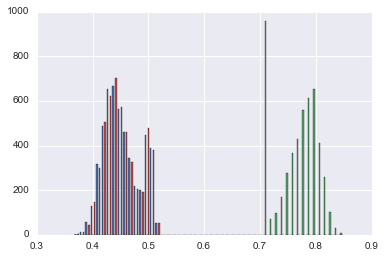

In [61]:
#define problem parameters
#dt = 2.1e-5
tfinal = .2
q = -5*2*np.pi
c = 2*np.pi*30
N = 10000
states = generate_states(2000,6000,2000,0,5000)
#print(np.mean(np.abs(states[:,1])**2))
ts = time.time()
#t,m,s = solve_TWA()
tm = time.time()
#states = generate_states(100,4800,100,0,500)
#t1,m1,s1,sol = solve_TWA_fixed()
te = time.time()
print(tm-ts)
print(te-tm)
plt.hist(np.real(states),bins=50);

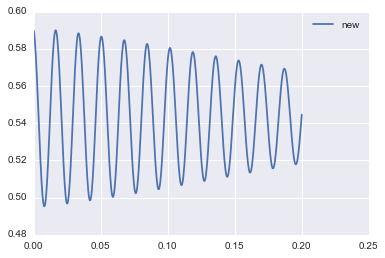

In [53]:
#sol1 = np.asarray(sol)
#plt.plot(t1,np.mean(msqr(sol1).real, axis = 0)[:,1],label='magfirst')
#plt.plot(t1,m1,label='old')
plt.plot(t,m,label='new')
plt.legend()
